# Automated Multi-Fold Multi-Stream Training and Fusion Pipeline

This notebook automates the training and evaluation process for all 25 folds and 4 streams (J, B, JM, BM) of the MP-GCN model on the Playground dataset. It:

1. Runs all 25 folds automatically (one at a time with 5-minute cooldown between folds)
2. Trains all 4 streams per fold (J, B, JM, BM) with 1-minute cooldown between streams
3. Performs per-fold late fusion
4. Computes which fold yields the best fused accuracy
5. Creates a fully automatic pipeline that runs everything in one execution
6. Redirects all logs to files in /workdir/logs


In [17]:
import os
import yaml
import numpy as np
import torch
import subprocess
import json
import pandas as pd
import time
import sys
import logging
from types import SimpleNamespace
from torch.utils.data import DataLoader, WeightedRandomSampler
from src.dataset import create as create_dataset
from src.model.MPGCN import MPGCN
from src.scheduler import create as create_scheduler
from tqdm.notebook import tqdm
from datetime import datetime
from contextlib import redirect_stdout, redirect_stderr
from io import StringIO


In [2]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080 Ti'

In [3]:
torch.set_float32_matmul_precision("medium")

D:\mpgcn-playground-scenes\.venv\Lib\site-packages\torch\__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  _C._set_float32_matmul_precision(precision)


## Configuration and Logging Setup


In [4]:
# Global configuration
ALL_FOLDS = [f"{i:02d}" for i in range(25)]  # 00-24
ALL_STREAMS = ["J", "B", "JM", "BM"]
EVALUATE_ONLY = False  # Set True to skip training and just run eval on existing checkpoints
BASE_WORKDIR = "./workdir"
LOGS_DIR = os.path.join(BASE_WORKDIR, "logs")

# Create logs directory
os.makedirs(LOGS_DIR, exist_ok=True)

# Create results directory for this run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RESULTS_DIR = os.path.join(BASE_WORKDIR, f"fusion_results_{timestamp}")
os.makedirs(RESULTS_DIR, exist_ok=True)

# Setup logging
def setup_logger(name, log_file, level=logging.INFO):
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    
    # File handler
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    
    # Create logger
    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.addHandler(file_handler)
    
    return logger

# Main logger
main_log_file = os.path.join(LOGS_DIR, f"pipeline_{timestamp}.log")
main_logger = setup_logger('main', main_log_file)

# Only display critical messages in the notebook
notebook_handler = logging.StreamHandler(sys.stdout)
notebook_handler.setLevel(logging.CRITICAL)
main_logger.addHandler(notebook_handler)

# Log initial configuration
main_logger.info(f"Starting pipeline with timestamp: {timestamp}")
main_logger.info(f"Processing {len(ALL_FOLDS)} folds: {ALL_FOLDS}")
main_logger.info(f"Processing {len(ALL_STREAMS)} streams: {ALL_STREAMS}")
main_logger.info(f"Evaluate only mode: {EVALUATE_ONLY}")
main_logger.info(f"Results will be saved to: {RESULTS_DIR}")
main_logger.info(f"Logs will be saved to: {LOGS_DIR}")

# Print minimal info to notebook
print(f"Pipeline started. Logs will be saved to: {LOGS_DIR}")
print(f"Results will be saved to: {RESULTS_DIR}")

Pipeline started. Logs will be saved to: ./workdir\logs
Results will be saved to: ./workdir\fusion_results_20251129_180945


## Stream Training Function


In [5]:
def run_stream(fold_id, stream_type, evaluate_only=False):
    """Train and evaluate a single stream for a specific fold
    
    Args:
        fold_id (str): Fold ID (e.g., "06")
        stream_type (str): Stream type ("J", "B", "JM", "BM")
        evaluate_only (bool): If True, skip training and just evaluate
        
    Returns:
        tuple: (work_dir, accuracy) - Directory with results and evaluation accuracy
    """
    # Setup stream-specific logger
    log_file = os.path.join(LOGS_DIR, f"fold_{fold_id}_{stream_type}.log")
    logger = setup_logger(f'fold_{fold_id}_{stream_type}', log_file)
    
    logger.info(f"Starting processing for fold {fold_id}, stream {stream_type}")
    
    # Redirect stdout and stderr to the log file
    log_capture = StringIO()
    with redirect_stdout(log_capture), redirect_stderr(log_capture):
        try:
            config_template = f"config/playground/mpgcn_{stream_type}.yaml"
            with open(config_template, "r") as f:
                cfg = yaml.safe_load(f)

            # Replace fold placeholder in paths
            cfg["dataset_args"]["root_folder"] = cfg["dataset_args"]["root_folder"].replace("{ID}", fold_id)
            cfg["dataset_args"]["object_folder"] = cfg["dataset_args"]["object_folder"].replace("{ID}", fold_id)
            cfg["dataset_args"]["stream_type"] = stream_type
            cfg["dataset_args"]["fold_id"] = fold_id

            # Resolve fold data directory in a cross-platform and robust way
            fold_dir_default = os.path.join(BASE_WORKDIR, f"fold_{fold_id}")
            fold_dir_double = os.path.join(BASE_WORKDIR, "workdir", f"fold_{fold_id}")
            # Prefer directory that actually contains expected data files
            expected_file = os.path.join(fold_dir_default, "train_data.npy")
            if os.path.exists(expected_file):
                resolved_fold_dir = fold_dir_default
            else:
                alt_expected = os.path.join(fold_dir_double, "train_data.npy")
                resolved_fold_dir = fold_dir_double if os.path.exists(alt_expected) else fold_dir_default
            # Override YAML-provided paths with resolved ones to avoid mixed separators and wrong roots
            cfg["dataset_args"]["root_folder"] = os.path.normpath(resolved_fold_dir)
            cfg["dataset_args"]["object_folder"] = os.path.normpath(resolved_fold_dir)

            # Ensure work_dir uses os.path.join for Windows/mac compatibility
            cfg["work_dir"] = os.path.join(BASE_WORKDIR, f"fold_{fold_id}_{stream_type}")
            cfg.setdefault("scheduler_args", {}).setdefault(cfg["lr_scheduler"], {})["max_epoch"] = 70

            # Convert to namespaces
            args = SimpleNamespace(**cfg)
            args.dataset_args = SimpleNamespace(**args.dataset_args)
            args.model_args = SimpleNamespace(**args.model_args)
            args.optimizer_args = SimpleNamespace(**args.optimizer_args)
            args.scheduler_args = SimpleNamespace(**args.scheduler_args)

            # Dataset
            logger.info("Creating dataset")
            feeders, data_shape, num_class, A, parts = create_dataset(
                args.dataset,
                debug=False,
                **vars(args.dataset_args)
            )
            logger.info(f"Train samples: {len(feeders['train'])}, eval samples: {len(feeders['eval'])}")

            # Sampler (no replacement)
            train_labels = np.array([int(y) for _, y, _, _ in feeders["train"]])
            class_counts = np.bincount(train_labels, minlength=num_class) + 1e-6
            class_weights = 1.0 / class_counts
            sample_weights = class_weights[train_labels]
            train_sampler = WeightedRandomSampler(
                weights=torch.tensor(sample_weights, dtype=torch.float32),
                num_samples=len(train_labels),
                replacement=False,
            )

            train_loader = DataLoader(
                feeders["train"],
                batch_size=args.dataset_args.train_batch_size,
                num_workers=4 * len(args.gpus),
                pin_memory=True,
                sampler=train_sampler,
                shuffle=False,
                drop_last=True,
            )

            eval_loader = DataLoader(
                feeders["eval"],
                batch_size=args.dataset_args.eval_batch_size,
                num_workers=4 * len(args.gpus),
                pin_memory=True,
                shuffle=False,
                drop_last=False,
            )

            # Model/optim/scheduler
            logger.info("Setting up model, optimizer, and scheduler")
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            model = MPGCN(
                data_shape=data_shape,
                num_class=num_class,
                A=torch.Tensor(A),
                parts=parts,
                num_areas=int(np.max(feeders["train"].area_ids)) + 1,
                **vars(args.model_args),
            ).to(device)

            def _to_dict(obj):
                if isinstance(obj, dict):
                    return obj
                return vars(obj)

            optimizer_cfg = _to_dict(getattr(args.optimizer_args, args.optimizer))
            optimizer_cls = getattr(torch.optim, args.optimizer)
            optimizer = optimizer_cls(model.parameters(), **optimizer_cfg)

            sched_cfg = _to_dict(getattr(args.scheduler_args, args.lr_scheduler))
            lr_scheduler = create_scheduler(args.lr_scheduler, len(train_loader), **sched_cfg)
            eval_interval, lr_lambda = lr_scheduler.get_lambda()
            scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

            class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
            criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

            max_epoch = sched_cfg.get("max_epoch", 100)
            best_acc = 0
            save_dir = args.work_dir
            os.makedirs(save_dir, exist_ok=True)

            if not evaluate_only:
                logger.info(f"Starting training for {max_epoch} epochs")
                for epoch in range(max_epoch):
                    model.train()
                    running_loss = 0.0
                    correct = 0
                    total = 0
                    for data, target, _, area_id in train_loader:
                        assert data.dim() == 5, f"Expected 5D (N, C, T, V, M), got {data.shape}"
                        assert area_id.dim() == 1, f"Bad area_id shape {area_id.shape}"
                        if data.dim() == 5:
                            data = data.unsqueeze(1)
                        data = data.float().to(device)
                        target = target.long().to(device)
                        area_id = area_id.long().to(device)

                        optimizer.zero_grad()
                        out, _ = model(data, area_id)
                        loss = criterion(out, target)
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                        running_loss += loss.item() * data.size(0)
                        preds = out.argmax(1)
                        correct += preds.eq(target).sum().item()
                        total += target.size(0)

                    train_acc = correct / total
                    logger.info(f"Epoch {epoch+1}/{max_epoch} train_loss={running_loss/total:.4f} acc={train_acc:.4f}")

                    model.eval()
                    eval_correct, eval_total = 0, 0
                    with torch.no_grad():
                        for data, target, _, area_id in eval_loader:
                            assert data.dim() == 5, f"Expected 5D (N, C, T, V, M), got {data.shape}"
                            assert area_id.dim() == 1, f"Bad area_id shape {area_id.shape}"
                            if data.dim() == 5:
                                data = data.unsqueeze(1)
                            data = data.float().to(device)
                            target = target.long().to(device)
                            area_id = area_id.long().to(device)
                            out, _ = model(data, area_id)
                            preds = out.argmax(1)
                            eval_correct += preds.eq(target).sum().item()
                            eval_total += target.size(0)
                    eval_acc = eval_correct / eval_total
                    logger.info(f"Eval acc={eval_acc:.4f}")

                    if eval_acc > best_acc:
                        best_acc = eval_acc
                        torch.save({"model": model.state_dict()}, os.path.join(save_dir, "best.pth.tar"))
                        logger.info(f"Saved best model (acc={best_acc:.4f})")
            else:
                logger.info("Evaluate-only mode: skipping training")

            # Deterministic eval + save score
            best_ckpt = os.path.join(save_dir, "best.pth.tar")
            if os.path.exists(best_ckpt):
                state = torch.load(best_ckpt, map_location="cpu")
                model.load_state_dict(state["model"])
                logger.info("Loaded best checkpoint")
            else:
                logger.warning("Best checkpoint not found, using current weights")

            logger.info("Running final evaluation")
            model.eval()
            all_logits, all_labels, all_names = [], [], []
            with torch.no_grad():
                for data, target, names, area_id in eval_loader:
                    assert data.dim() == 5, f"Expected 5D (N, C, T, V, M), got {data.shape}"
                    assert area_id.dim() == 1, f"Bad area_id shape {area_id.shape}"
                    if data.dim() == 5:
                        data = data.unsqueeze(1)
                    data = data.float().to(device)
                    target = target.long().to(device)
                    area_id = area_id.long().to(device)
                    out, _ = model(data, area_id)
                    all_logits.append(out.cpu().numpy())
                    all_labels.append(target.cpu().numpy())
                    all_names.extend(names)

            logits_arr = np.concatenate(all_logits, axis=0)
            labels_arr = np.concatenate(all_labels, axis=0)
            names_arr = np.array(all_names)

            # Calculate final accuracy
            preds = logits_arr.argmax(axis=1)
            final_acc = (preds == labels_arr).mean()
            
            np.savez(os.path.join(args.work_dir, "score_eval.npz"), 
                    logits=logits_arr, labels=labels_arr, names=names_arr)
            logger.info(f"Saved score_eval.npz to {args.work_dir} (acc={final_acc:.4f})")
            
            # Log captured output to file
            logger.debug(log_capture.getvalue())
            
            # Print minimal info to notebook
            print(f"Completed fold {fold_id}, stream {stream_type} with accuracy: {final_acc:.4f}")
            
            return args.work_dir, final_acc
            
        except Exception as e:
            logger.exception(f"Error in run_stream: {e}")
            # Print error to notebook
            print(f"Error processing fold {fold_id}, stream {stream_type}: {e}")
            raise

## Fusion Function


In [6]:
def run_fusion(fold_id, streams=ALL_STREAMS, weights=None):
    """Run late fusion for a specific fold using the ensemble script
    
    Args:
        fold_id (str): Fold ID (e.g., "06")
        streams (list): List of stream types to fuse
        weights (list, optional): Weights for each stream
        
    Returns:
        float: Fusion accuracy
    """
    # Setup fusion-specific logger
    log_file = os.path.join(LOGS_DIR, f"fold_{fold_id}_fusion.log")
    logger = setup_logger(f'fold_{fold_id}_fusion', log_file)
    
    logger.info(f"Running fusion for fold {fold_id}, streams: {streams}")
    
    try:
        # Check if all score files exist
        for stream in streams:
            score_path = f"{BASE_WORKDIR}/fold_{fold_id}_{stream}/score_eval.npz"
            if not os.path.exists(score_path):
                error_msg = f"Missing score file for fold {fold_id}, stream {stream}: {score_path}"
                logger.error(error_msg)
                raise FileNotFoundError(error_msg)
        
        # Build command
        cmd = [
            "python", "script/ensemble_playground.py",
            "--fold", fold_id,
            "--streams"] + streams + [
            "--workdir", BASE_WORKDIR,
        ]
        
        if weights:
            cmd.extend(["--weights"] + [str(w) for w in weights])
        
        # Run ensemble script
        logger.info(f"Running command: {' '.join(cmd)}")
        result = subprocess.run(cmd, capture_output=True, text=True)
        logger.info(f"Command output: {result.stdout}")
        if result.stderr:
            logger.warning(f"Command errors: {result.stderr}")
        
        # Extract accuracy from output
        accuracy = None
        for line in result.stdout.split('\n'):
            if "Accuracy:" in line:
                accuracy = float(line.split()[-1])
                logger.info(f"Extracted accuracy from output: {accuracy}")
        
        # If we couldn't extract from output, read from the JSON file
        if accuracy is None:
            fusion_json = f"{BASE_WORKDIR}/fold_{fold_id}_ensemble/fused_score_eval_fold{fold_id}.json"
            if os.path.exists(fusion_json):
                with open(fusion_json, 'r') as f:
                    data = json.load(f)
                    accuracy = data['metrics']['accuracy']
                    logger.info(f"Extracted accuracy from JSON: {accuracy}")
        
        if accuracy is None:
            logger.error("Could not determine fusion accuracy")
            raise ValueError("Could not determine fusion accuracy")
        
        # Print minimal info to notebook
        print(f"Completed fusion for fold {fold_id} with accuracy: {accuracy:.4f}")
        
        return accuracy
        
    except Exception as e:
        logger.exception(f"Error in run_fusion: {e}")
        # Print error to notebook
        print(f"Error running fusion for fold {fold_id}: {e}")
        raise

## In-Notebook Fusion Function (Alternative)


In [7]:
def run_notebook_fusion(fold_id, streams=ALL_STREAMS, weights=None):
    """Run late fusion for a specific fold directly in the notebook
    
    Args:
        fold_id (str): Fold ID (e.g., "06")
        streams (list): List of stream types to fuse
        weights (list, optional): Weights for each stream
        
    Returns:
        float: Fusion accuracy
    """
    # Setup fusion-specific logger
    log_file = os.path.join(LOGS_DIR, f"fold_{fold_id}_notebook_fusion.log")
    logger = setup_logger(f'fold_{fold_id}_notebook_fusion', log_file)
    
    logger.info(f"Running in-notebook fusion for fold {fold_id}, streams: {streams}")
    
    try:
        if weights is None:
            weights = [1.0] * len(streams)
        weights = np.array(weights) / sum(weights)
        logger.info(f"Using weights: {weights}")
        
        scores = []
        labels_ref = None
        names_ref = None
        
        for s in streams:
            path = f"{BASE_WORKDIR}/fold_{fold_id}_{s}/score_eval.npz"
            logger.info(f"Loading scores from {path}")
            d = np.load(path)
            if labels_ref is None:
                labels_ref = d["labels"]
                names_ref = d["names"]
                logger.info(f"Reference labels shape: {labels_ref.shape}")
            else:
                if not np.array_equal(labels_ref, d["labels"]):
                    error_msg = "Label mismatch across streams"
                    logger.error(error_msg)
                    raise ValueError(error_msg)
                if not np.array_equal(names_ref, d["names"]):
                    error_msg = "Name/order mismatch across streams"
                    logger.error(error_msg)
                    raise ValueError(error_msg)
            scores.append(d["logits"])
            logger.info(f"Loaded logits shape: {d['logits'].shape}")

        # Weighted fusion
        logger.info("Performing weighted fusion")
        fused = np.zeros_like(scores[0])
        for score, weight in zip(scores, weights):
            fused += score * weight
            
        preds = fused.argmax(1)
        final_acc = (preds == labels_ref).mean()
        logger.info(f"In-notebook fusion accuracy: {final_acc:.4f}")
        
        # Save fusion results
        fusion_dir = f"{BASE_WORKDIR}/fold_{fold_id}_ensemble"
        os.makedirs(fusion_dir, exist_ok=True)
        output_path = os.path.join(fusion_dir, f"notebook_fused_logits_fold{fold_id}.npz")
        logger.info(f"Saving fusion results to {output_path}")
        np.savez(
            output_path,
            logits=fused,
            labels=labels_ref,
            names=names_ref,
            preds=preds,
        )
        
        # Print minimal info to notebook
        print(f"Completed in-notebook fusion for fold {fold_id} with accuracy: {final_acc:.4f}")
        
        return final_acc
        
    except Exception as e:
        logger.exception(f"Error in run_notebook_fusion: {e}")
        # Print error to notebook
        print(f"Error running in-notebook fusion for fold {fold_id}: {e}")
        raise

## Master Pipeline Function with Cooldowns


In [8]:
def run_master_pipeline(folds=ALL_FOLDS, streams=ALL_STREAMS, evaluate_only=EVALUATE_ONLY):
    """Run the complete pipeline for all folds and streams with cooldown periods
    
    Args:
        folds (list): List of fold IDs to process
        streams (list): List of stream types to process
        evaluate_only (bool): If True, skip training and just evaluate
        
    Returns:
        pd.DataFrame: Summary of results for all folds
    """
    start_time = datetime.now()
    main_logger.info(f"Starting master pipeline at {start_time}")
    main_logger.info(f"Processing {len(folds)} folds: {folds}")
    main_logger.info(f"Processing {len(streams)} streams: {streams}")
    main_logger.info(f"Evaluate only mode: {evaluate_only}")
    main_logger.info(f"Using 5-minute cooldown between folds")
    main_logger.info(f"Using 1-minute cooldown between streams")
    
    # Print minimal info to notebook
    print(f"Starting pipeline at {start_time}")
    print(f"Processing {len(folds)} folds with 5-minute cooldown between folds")
    print(f"Processing {len(streams)} streams with 1-minute cooldown between streams")
    
    # Initialize results tracking
    results = {}
    
    # Process each fold (one at a time with cooldown)
    for i, fold_id in enumerate(folds):
        fold_start_time = datetime.now()
        main_logger.info(f"Processing fold {fold_id} (started at {fold_start_time})")
        print(f"Processing fold {fold_id} ({i+1}/{len(folds)}) started at {fold_start_time}")
        
        # Initialize fold results
        results[fold_id] = {
            "streams": {},
            "fusion": None,
            "work_dirs": []
        }
        
        # Process each stream for this fold (with cooldown between streams)
        for j, stream in enumerate(streams):
            stream_start_time = datetime.now()
            main_logger.info(f"Processing fold {fold_id}, stream {stream} (started at {stream_start_time})")
            print(f"  Processing stream {stream} ({j+1}/{len(streams)})")
            
            try:
                work_dir, accuracy = run_stream(fold_id, stream, evaluate_only)
                results[fold_id]["streams"][stream] = accuracy
                results[fold_id]["work_dirs"].append(work_dir)
                main_logger.info(f"Completed fold {fold_id}, stream {stream} with accuracy: {accuracy:.4f}")
            except Exception as e:
                main_logger.error(f"Error processing fold {fold_id}, stream {stream}: {e}")
                results[fold_id]["streams"][stream] = None
            
            # Add 1-minute cooldown between streams (except after the last stream)
            if j < len(streams) - 1:
                main_logger.info(f"Cooldown: waiting 1 minute before next stream")
                print(f"  Cooldown: waiting 1 minute before next stream...")
                time.sleep(60)  # 1 minute in seconds
        
        # Run fusion if all streams were processed successfully
        if all(results[fold_id]["streams"].get(s) is not None for s in streams):
            try:
                # Try script-based fusion first
                fusion_acc = run_fusion(fold_id, streams)
                results[fold_id]["fusion"] = fusion_acc
                main_logger.info(f"Completed fusion for fold {fold_id} with accuracy: {fusion_acc:.4f}")
            except Exception as e:
                main_logger.error(f"Error running script fusion for fold {fold_id}: {e}")
                try:
                    # Fall back to in-notebook fusion
                    main_logger.info("Falling back to in-notebook fusion")
                    print("  Falling back to in-notebook fusion...")
                    fusion_acc = run_notebook_fusion(fold_id, streams)
                    results[fold_id]["fusion"] = fusion_acc
                    main_logger.info(f"Completed in-notebook fusion for fold {fold_id} with accuracy: {fusion_acc:.4f}")
                except Exception as e2:
                    main_logger.error(f"Error running in-notebook fusion for fold {fold_id}: {e2}")
                    results[fold_id]["fusion"] = None
        
        fold_end_time = datetime.now()
        fold_duration = fold_end_time - fold_start_time
        main_logger.info(f"Completed fold {fold_id} in {fold_duration} (ended at {fold_end_time})")
        print(f"Completed fold {fold_id} in {fold_duration}")
        
        # Save intermediate results after each fold
        intermediate_results_file = os.path.join(RESULTS_DIR, f"fusion_results_intermediate_{timestamp}.json")
        with open(intermediate_results_file, "w") as f:
            json.dump(results, f, indent=2)
        main_logger.info(f"Saved intermediate results to {intermediate_results_file}")
        
        # Add 5-minute cooldown between folds (except after the last fold)
        if i < len(folds) - 1:
            main_logger.info(f"Cooldown: waiting 5 minutes before next fold")
            print(f"Cooldown: waiting 5 minutes before next fold...")
            time.sleep(300)  # 5 minutes in seconds
    
    # Create summary dataframe
    summary_data = []
    for fold_id in folds:
        if fold_id in results:
            row = {"Fold": fold_id}
            for stream in streams:
                row[f"{stream}_Acc"] = results[fold_id]["streams"].get(stream)
            row["Fusion_Acc"] = results[fold_id]["fusion"]
            summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Save results to JSON
    results_file = os.path.join(RESULTS_DIR, f"fusion_results_{timestamp}.json")
    with open(results_file, "w") as f:
        json.dump(results, f, indent=2)
    main_logger.info(f"Saved detailed results to {results_file}")
    print(f"Saved detailed results to {results_file}")
    
    # Save summary to CSV
    summary_file = os.path.join(RESULTS_DIR, f"fusion_summary_{timestamp}.csv")
    summary_df.to_csv(summary_file, index=False)
    main_logger.info(f"Saved summary to {summary_file}")
    print(f"Saved summary to {summary_file}")
    
    end_time = datetime.now()
    total_duration = end_time - start_time
    main_logger.info(f"Master pipeline completed in {total_duration} (started: {start_time}, ended: {end_time})")
    print(f"Master pipeline completed in {total_duration}")
    print(f"Started: {start_time}, ended: {end_time}")
    
    return summary_df

## Run Pipeline for All Folds and Streams


In [9]:
# Run the complete pipeline
summary_df = run_master_pipeline()

Starting pipeline at 2025-11-29 18:10:02.723957
Processing 25 folds with 5-minute cooldown between folds
Processing 4 streams with 1-minute cooldown between streams
Processing fold 00 (1/25) started at 2025-11-29 18:10:02.724960
  Processing stream J (1/4)
  Cooldown: waiting 1 minute before next stream...
  Processing stream B (2/4)
  Cooldown: waiting 1 minute before next stream...
  Processing stream JM (3/4)
  Cooldown: waiting 1 minute before next stream...
  Processing stream BM (4/4)
Error running fusion for fold 00: Could not determine fusion accuracy
  Falling back to in-notebook fusion...
Completed in-notebook fusion for fold 00 with accuracy: 0.6519
Completed fold 00 in 1:22:00.628601
Cooldown: waiting 5 minutes before next fold...
Processing fold 01 (2/25) started at 2025-11-29 19:37:03.354716
  Processing stream J (1/4)
  Cooldown: waiting 1 minute before next stream...
  Processing stream B (2/4)
  Cooldown: waiting 1 minute before next stream...
  Processing stream JM (3

## Find Best Fold


In [10]:
# Recreate globals needed for visualization
ALL_STREAMS = ["J", "B", "JM", "BM"]
ALL_FOLDS = [f"{i:02d}" for i in range(25)]
BASE_WORKDIR = "./workdir"

In [11]:
RESULTS_DIR = "./workdir/fusion_results_20251129_180945"

summary_file = os.path.join(RESULTS_DIR, "fusion_summary_20251129_180945.csv")
summary_df = pd.read_csv(summary_file)

display(summary_df)

,Fold,J_Acc,B_Acc,JM_Acc,BM_Acc,Fusion_Acc
0,0,0.675768,0.668942,0.648464,0.648464,0.651877
1,1,0.665529,0.679181,0.658703,0.651877,0.682594
2,2,0.668966,0.686207,0.668966,0.675862,0.672414
3,3,0.688356,0.667808,0.674658,0.671233,0.684932
4,4,0.664430,0.681208,0.661074,0.667785,0.667785
5,5,0.664407,0.684746,0.664407,0.667797,0.681356
6,6,0.676056,0.672535,0.658451,0.661972,0.654930
7,7,0.672414,0.672414,0.668966,0.668966,0.675862
8,8,0.695205,0.674658,0.674658,0.674658,0.681507
9,9,0.665505,0.700348,0.689895,0.665505,0.662021


In [20]:
# Sort by fusion accuracy to find the best fold
sorted_df = summary_df.sort_values(by="Fusion_Acc", ascending=False).reset_index(drop=True)
print("Folds sorted by fusion accuracy (best to worst):")
display(sorted_df)

# Get the best fold
best_fold = sorted_df.iloc[0]["Fold"]
best_fold = f"{int(best_fold):02d}"   # ← FIX HERE
best_fusion_acc = sorted_df.iloc[0]["Fusion_Acc"]

print(f"\nBest fold: {best_fold} with fusion accuracy: {best_fusion_acc:.4f}")
print(f"Stream accuracies for best fold:")
for stream in ALL_STREAMS:
    acc = sorted_df.iloc[0][f"{stream}_Acc"]
    print(f"  {stream}: {acc:.4f}")

print(f"\nBest fold score files:")
for stream in ALL_STREAMS:
    print(f"  {stream}: {BASE_WORKDIR}/fold_{best_fold}_{stream}/score_eval.npz")
print(f"  Fusion: {BASE_WORKDIR}/fold_{best_fold}_ensemble/fused_score_eval_fold{best_fold}.json")

Folds sorted by fusion accuracy (best to worst):


,Fold,J_Acc,B_Acc,JM_Acc,BM_Acc,Fusion_Acc
0,22,0.693103,0.717241,0.682759,0.693103,0.696552
1,10,0.684932,0.678082,0.664384,0.671233,0.695205
2,17,0.692833,0.696246,0.679181,0.651877,0.689420
3,23,0.700680,0.687075,0.690476,0.680272,0.687075
4,19,0.703833,0.679443,0.693380,0.682927,0.686411
5,3,0.688356,0.667808,0.674658,0.671233,0.684932
6,1,0.665529,0.679181,0.658703,0.651877,0.682594
7,13,0.688963,0.678930,0.665552,0.668896,0.682274
8,24,0.674740,0.685121,0.660900,0.657439,0.681661
9,8,0.695205,0.674658,0.674658,0.674658,0.681507



Best fold: 22 with fusion accuracy: 0.6966
Stream accuracies for best fold:
  J: 0.6931
  B: 0.7172
  JM: 0.6828
  BM: 0.6931

Best fold score files:
  J: ./workdir/fold_22_J/score_eval.npz
  B: ./workdir/fold_22_B/score_eval.npz
  JM: ./workdir/fold_22_JM/score_eval.npz
  BM: ./workdir/fold_22_BM/score_eval.npz
  Fusion: ./workdir/fold_22_ensemble/fused_score_eval_fold22.json


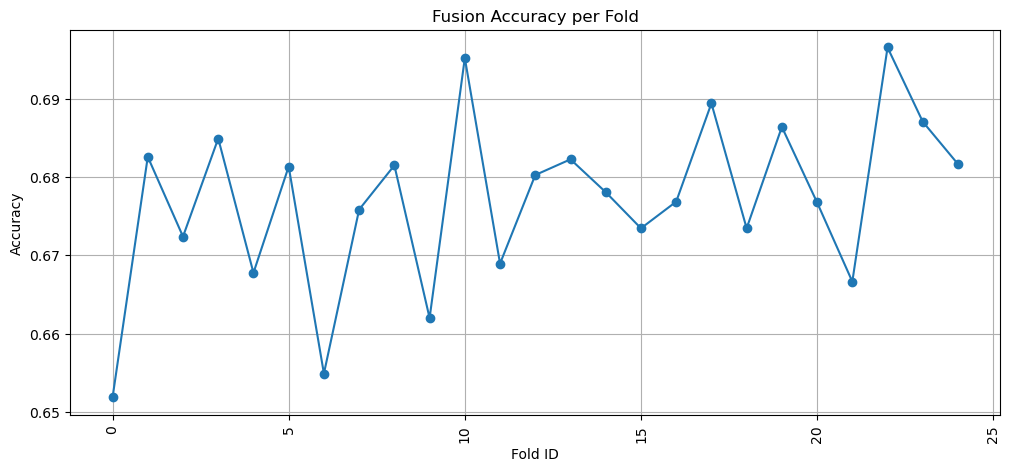

In [21]:
import matplotlib.pyplot as plt

# Plot all folds (fusion accuracy)
plt.figure(figsize=(12,5))
plt.plot(summary_df["Fold"], summary_df["Fusion_Acc"], marker="o")
plt.xticks(rotation=90)
plt.title("Fusion Accuracy per Fold")
plt.xlabel("Fold ID")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

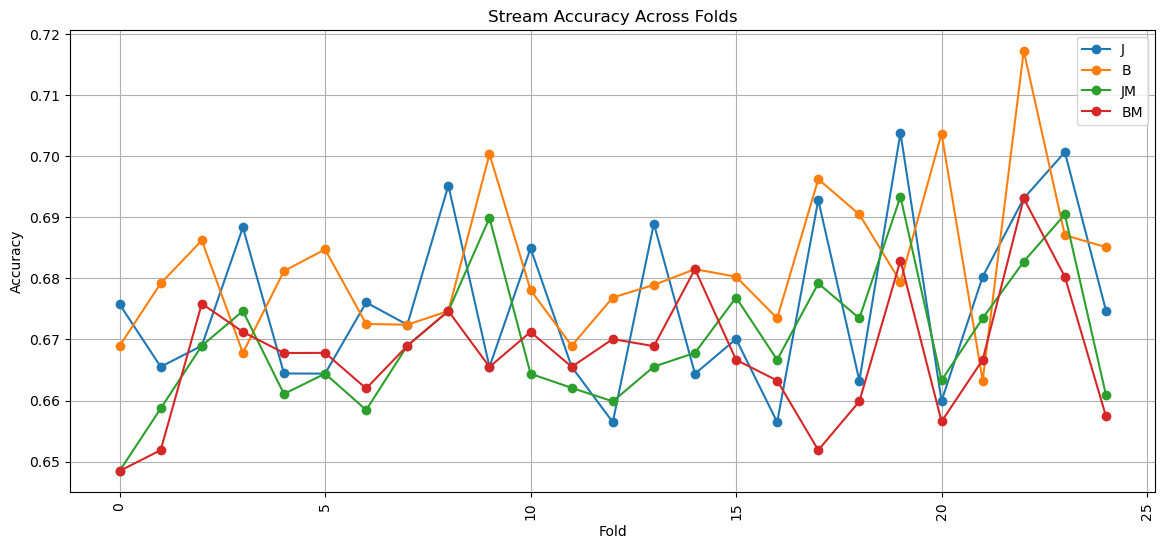

In [22]:
plt.figure(figsize=(14,6))
for stream in ALL_STREAMS:
    plt.plot(summary_df["Fold"], summary_df[f"{stream}_Acc"], marker="o", label=stream)

plt.xticks(rotation=90)
plt.title("Stream Accuracy Across Folds")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

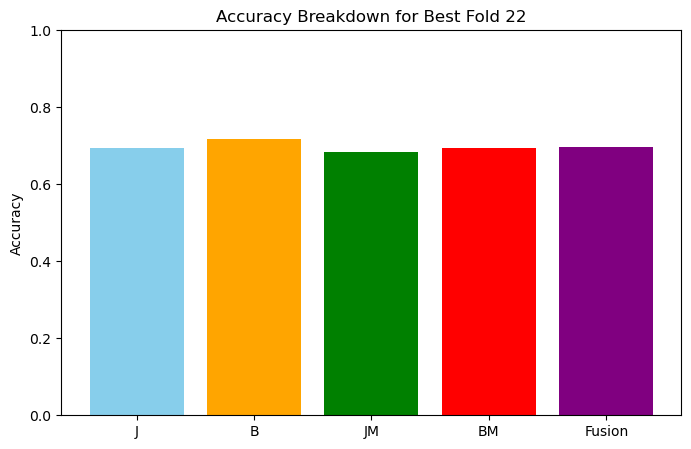

In [23]:
best_row = sorted_df.iloc[0]
labels = ALL_STREAMS + ["Fusion"]
values = [best_row[f"{s}_Acc"] for s in ALL_STREAMS] + [best_row["Fusion_Acc"]]

plt.figure(figsize=(8,5))
plt.bar(labels, values, color=["skyblue","orange","green","red","purple"])
plt.title(f"Accuracy Breakdown for Best Fold {best_fold}")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

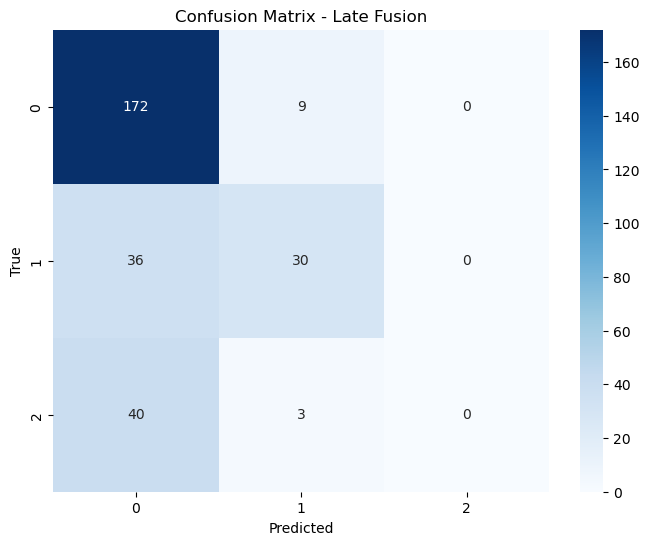

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

fused_path = f"{BASE_WORKDIR}/fold_{best_fold}_ensemble/notebook_fused_logits_fold{best_fold}.npz"
data = np.load(fused_path)

cm = confusion_matrix(data["labels"], data["preds"])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Late Fusion")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

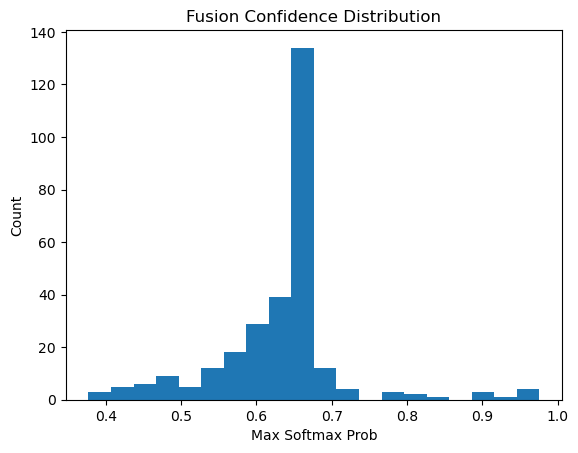

In [25]:
probs = torch.softmax(torch.tensor(data["logits"]), dim=1).numpy()
conf = probs.max(axis=1)

plt.hist(conf, bins=20)
plt.title("Fusion Confidence Distribution")
plt.xlabel("Max Softmax Prob")
plt.ylabel("Count")
plt.show()

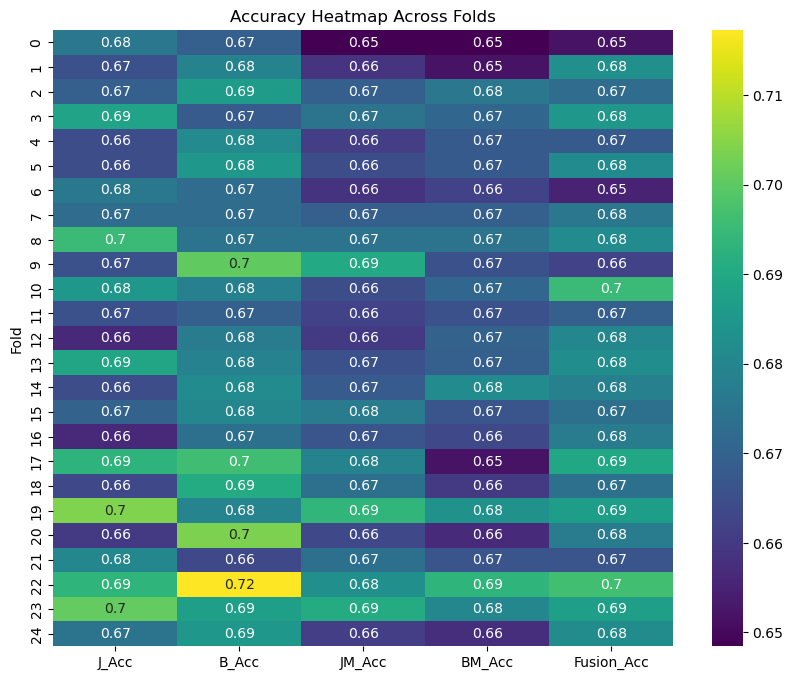

In [26]:
plt.figure(figsize=(10,8))
sns.heatmap(summary_df.set_index("Fold")[["J_Acc","B_Acc","JM_Acc","BM_Acc","Fusion_Acc"]],
            annot=True, cmap="viridis")
plt.title("Accuracy Heatmap Across Folds")
plt.show()

In [27]:
import json

fold_info = []
for fold in ALL_FOLDS:
    path = f"{BASE_WORKDIR}/fold_{fold}_J/score_eval.npz"
    if os.path.exists(path):
        fold_info.append({"Fold": fold, "Count": np.load(path)["labels"].shape[0]})

pd.DataFrame(fold_info)

,Fold,Count
0,00,293
1,01,293
2,02,290
3,03,292
4,04,298
5,05,295
6,06,284
7,07,290
8,08,292
9,09,287


## Run Pipeline for Specific Folds (Optional)


In [ ]:
# Example: Run only specific folds
# selected_folds = ["00", "01", "02"]
# summary_df_subset = run_master_pipeline(folds=selected_folds)

## Run Evaluation Only (Optional)


In [ ]:
# Example: Run evaluation only (no training) for all folds
# summary_df_eval = run_master_pipeline(evaluate_only=True)